In [3]:
!pip install scikit-learn


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------------- -------------- 5.2/8.1 MB 29.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 29.4 MB/s  0:00:00
   ---------------------------------------- 0.0/38.7 MB ? eta -:--:--
   -------- ------------------------------- 7.9/38.7 MB 37.4 MB/s eta 0:00:01
   ----------------- ---------------------- 16.5/38.7 MB 40.0 MB/s eta 0:00:01
   -------------------------- ------------- 26.0/38.7 MB 41.1 MB/s eta 0:00:01
   ----------------------------------- ---- 34.3/38.7 MB 40.4 MB/s eta 0:00:01
   ---------------------------------------- 38.7/38.7 MB 37.3 MB/s  0:00:01

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ------------------------

In [4]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import datetime
import typing
import requests
import time
import shutil
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



In [5]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

# Data Understanding - done by student A Emina Skrijelj


In [6]:
# Path to the Letter Recognition dataset
letter_data_path = "data"


def load_letter_data() -> pd.DataFrame:
    # loading the data
    input_file = os.path.join(letter_data_path, "letter-recognition.csv")
    raw_data = pd.read_csv(input_file, sep=",", header=0)

    def structure_letter_data(dataframe: pd.DataFrame) -> pd.DataFrame:
        structured_data = dataframe.copy()

        structured_data["letter"] = structured_data["letter"].astype(str)

        feature_cols = structured_data.columns.drop("letter")
        structured_data[feature_cols] = structured_data[feature_cols].apply(
            pd.to_numeric, errors="coerce"
        )

        return structured_data

    loaded_data = structure_letter_data(raw_data)

    return loaded_data


start_time_ld = now()
data = load_letter_data()
end_time_ld = now()

display(data.head())


,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [7]:

def check_outliers(
    data: pd.DataFrame,
    threshold: float = 2.2,
    exclude_columns: tuple = ('letter',)
) -> dict:
    """
    Identify potential outliers in numeric feature columns using z-scores.
    This is a simple, exploratory method used for data understanding purposes.
    """

    results = {}

    tmp = data.copy().reset_index(drop=True)

    # Select numeric columns only, excluding target variable
    numeric_columns = [
        col for col in tmp.columns
        if col not in exclude_columns and pd.api.types.is_numeric_dtype(tmp[col])
    ]

    for col in numeric_columns:
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        # Skip columns with no variance
        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std
        mask = np.abs(z_scores) > threshold

        outlier_indices = values[mask].index

        outlier_info = [
            {
                "index": int(idx),
                "z_score": float(z_scores.loc[idx])
            }
            for idx in outlier_indices
        ]

        results[col] = outlier_info

    return results

# Execute outlier detection
start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2)
end_time_co = now()

# Inspect report
start_time_ho = now()
print(outliers_report)
end_time_ho = now()

{'xbox ': [{'index': 9, 'z_score': 3.6464603288414508}, {'index': 27, 'z_score': 4.169141682372466}, {'index': 255, 'z_score': 2.60109762177942}, {'index': 354, 'z_score': 3.6464603288414508}, {'index': 384, 'z_score': 3.1237789753104357}, {'index': 402, 'z_score': 3.6464603288414508}, {'index': 423, 'z_score': 2.60109762177942}, {'index': 459, 'z_score': 2.60109762177942}, {'index': 497, 'z_score': 2.60109762177942}, {'index': 511, 'z_score': 2.60109762177942}, {'index': 539, 'z_score': 2.60109762177942}, {'index': 552, 'z_score': 4.691823035903481}, {'index': 569, 'z_score': 2.60109762177942}, {'index': 640, 'z_score': 2.60109762177942}, {'index': 654, 'z_score': 3.1237789753104357}, {'index': 738, 'z_score': 2.60109762177942}, {'index': 766, 'z_score': 2.60109762177942}, {'index': 779, 'z_score': 2.60109762177942}, {'index': 783, 'z_score': 3.1237789753104357}, {'index': 823, 'z_score': 2.60109762177942}, {'index': 844, 'z_score': 2.60109762177942}, {'index': 848, 'z_score': 2.60109

In [8]:

def calculate_distribution_properties(data: pd.DataFrame) -> dict:
    """
    Calculates skewness for all numerical feature columns
    in the Letter Recognition dataset.
    """

    # All numeric feature columns (exclude target)
    numeric_features = data.drop(columns=["letter"]).columns.tolist()

    skewness_series = data[numeric_features].skew()
    skewness_report = skewness_series.to_dict()

    return skewness_report


start_time_skew = now()
skew_report = calculate_distribution_properties(data)
end_time_skew = now()

print("Calculated Skewness (sorted):")
print(pd.Series(skew_report).sort_values(ascending=False))

Calculated Skewness (sorted):
x2bar     1.159975
xedge     1.057288
onpix     0.943373
xbox      0.715056
yedge     0.468343
x2ybar    0.288168
y2bar     0.286934
xy2bar    0.273728
width     0.234941
ybar      0.093471
xybar     0.090078
xedgey    0.049198
yedgex   -0.199507
ybox     -0.227967
height   -0.278249
xbar     -0.310079
dtype: float64


In [9]:
missing_counts = data.isna().sum()

print("Missing values per column:")
print(missing_counts)

Missing values per column:
letter    0
xbox      0
ybox      0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
x2ybar    0
xy2bar    0
xedge     0
xedgey    0
yedge     0
yedgex    0
dtype: int64


        min  max     mean       std
xbox      0   15  4.02355  1.913212
ybox      0   15  7.03550  3.304555
width     0   15  5.12185  2.014573
height    0   15  5.37245  2.261390
onpix     0   15  3.50585  2.190458
xbar      0   15  6.89760  2.026035
ybar      0   15  7.50045  2.325354
x2bar     0   15  4.62860  2.699968
y2bar     0   15  5.17865  2.380823
xybar     0   15  8.28205  2.488475
x2ybar    0   15  6.45400  2.631070
xy2bar    0   15  7.92900  2.080619
xedge     0   15  3.04610  2.332541
xedgey    0   15  8.33885  1.546722
yedge     0   15  3.69175  2.567073
yedgex    0   15  7.80120  1.617470


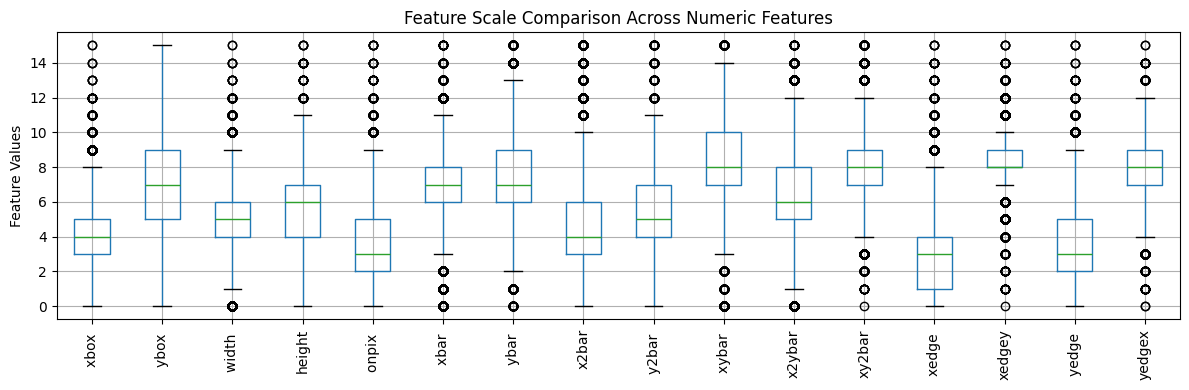

In [10]:
numeric_features = data.drop(columns=["letter"])

scale_summary = pd.DataFrame({
    "min": numeric_features.min(),
    "max": numeric_features.max(),
    "mean": numeric_features.mean(),
    "std": numeric_features.std()
})

print(scale_summary)

# Boxplots for Feature Scale Comparison

plt.figure(figsize=(12, 4))
numeric_features.boxplot()
plt.xticks(rotation=90)
plt.title("Feature Scale Comparison Across Numeric Features")
plt.ylabel("Feature Values")
plt.tight_layout()
plt.show()

In [ ]:
def visualizations(data: pd.DataFrame):

    #  class distribution of target variable
    fig1, ax1 = plt.subplots(figsize=(8, 5))

    data['letter'].value_counts().sort_index().plot(
        kind='bar',
        ax=ax1,
        edgecolor='black'
    )

    ax1.set_title('Distribution of Letter Classes (A–Z)')
    ax1.set_xlabel('Letter')
    ax1.set_ylabel('Frequency')
    plt.tight_layout()

    plt.savefig('visual_exploration_letter_distribution.png')
    plt.close(fig1)

    # Distribution of a representative feature
    fig2, ax2 = plt.subplots(figsize=(7, 5))

    ax2.hist(data['xbox '], bins=10, edgecolor='black')
    ax2.set_title('Distribution of Feature: xbox')
    ax2.set_xlabel('xbox value')
    ax2.set_ylabel('Frequency')
    plt.tight_layout()

    plt.savefig('visual_exploration_xbox_distribution.png')
    plt.close(fig2)

    letter_distribution = data['letter'].value_counts().to_dict()
    xbox_summary = data['xbox '].describe().to_dict()

    return {
        'figures_generated': 2,
        'description': 'Bar chart of letter class distribution and histogram of xbox feature.',
        'letter_class_distribution': letter_distribution,
        'xbox_summary_statistics': xbox_summary
    }


# Execution and Timing
start_time_vis = now()
vis_report = visualizations(data)
end_time_vis = now()


# Data preparation - done by student B Azra Sisic 12024721

In [ ]:
# Column name normalization

#  original column names for documentation
original_columns = data.columns.tolist()

# removing leading/trailing whitespace
data.columns = data.columns.str.strip()

normalized_columns = data.columns.tolist()

print("Original column names:")
print(original_columns)

print("\nNormalized column names:")
print(normalized_columns)


Original column names:
['letter', 'xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ', 'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ', 'xedgey', 'yedge ', 'yedgex']

Normalized column names:
['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar', 'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge', 'xedgey', 'yedge', 'yedgex']


In [ ]:
# target variable
y = data["letter"]

# feature matrix (all numeric descriptor columns)
X = data.drop(columns=["letter"])

print("Feature matrix shape (X):", X.shape)
print("Target vector shape (y):", y.shape)

print("\nFeature columns:")
print(X.columns.tolist())

print("\nTarget sample:")
print(y.head())


Feature matrix shape (X): (20000, 16)
Target vector shape (y): (20000,)

Feature columns:
['xbox', 'ybox', 'width', 'height', 'onpix', 'xbar', 'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge', 'xedgey', 'yedge', 'yedgex']

Target sample:
0    T
1    I
2    D
3    N
4    G
Name: letter, dtype: object


In [44]:
# initialize label encoder
label_encoder = LabelEncoder()

# encode target variable
y_encoded = label_encoder.fit_transform(y)

print("Encoded target shape:", y_encoded.shape)

print("\nClass mapping (letter -> encoded value):")
for cls, idx in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{cls} -> {idx}")

print("\nEncoded target sample:")
print(y_encoded[:10])

Encoded target shape: (20000,)

Class mapping (letter -> encoded value):
A -> 0
B -> 1
C -> 2
D -> 3
E -> 4
F -> 5
G -> 6
H -> 7
I -> 8
J -> 9
K -> 10
L -> 11
M -> 12
N -> 13
O -> 14
P -> 15
Q -> 16
R -> 17
S -> 18
T -> 19
U -> 20
V -> 21
W -> 22
X -> 23
Y -> 24
Z -> 25

Encoded target sample:
[19  8  3 13  6 18  1  0  9 12]


Scaled feature matrix shape: (20000, 16)

Summary statistics after scaling:
              xbox          ybox         width        height         onpix  \
mean -1.030287e-16  3.659295e-17 -8.242296e-17  1.417533e-16 -1.003642e-16   
std   1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   

              xbar          ybar         x2bar         y2bar         xybar  \
mean  1.104894e-16  4.156675e-17  1.747935e-16 -6.181722e-17  4.440892e-17   
std   1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   

            x2ybar        xy2bar         xedge        xedgey         yedge  \
mean  9.947598e-17 -1.083578e-16 -1.598721e-18 -4.732215e-16  6.039613e-17   
std   1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   

            yedgex  
mean  1.790568e-16  
std   1.000025e+00  


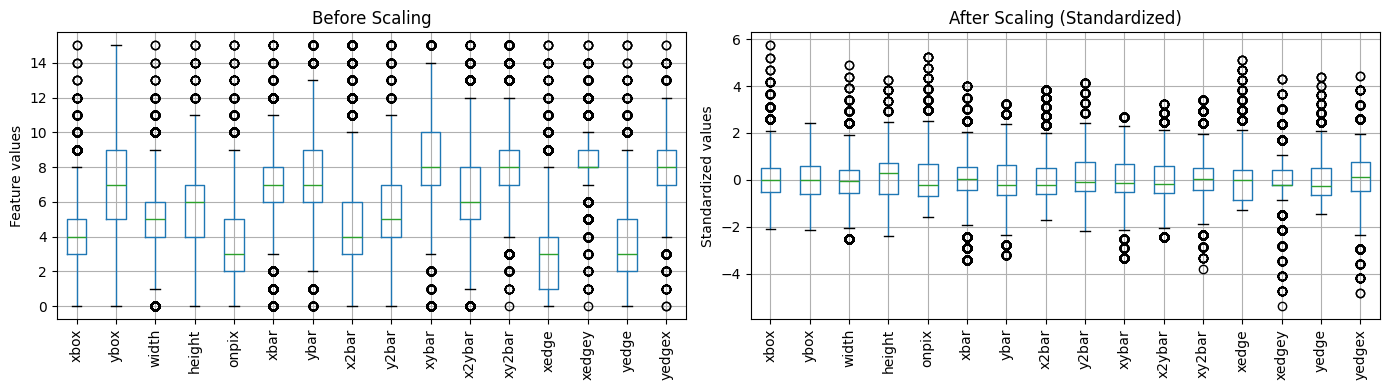

In [45]:
scaler = StandardScaler()

# fit scaler on the full feature matrix and transform
X_scaled = scaler.fit_transform(X)


X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


print("Scaled feature matrix shape:", X_scaled.shape)

print("\nSummary statistics after scaling:")
print(X_scaled.describe().loc[["mean", "std"]])



fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# before scaling
X.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].set_ylabel("Feature values")
axes[0].tick_params(axis='x', rotation=90)

# after scaling
X_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (Standardized)")
axes[1].set_ylabel("Standardized values")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig("feature_scaling_comparison_boxplot.png", dpi=300)

plt.show()

plt.close(fig)

